In [146]:
import numpy as np
import pandas as pd
import FinanceDataReader as fdr
        
import matplotlib as mpl
%matplotlib inline
mpl.use('Agg')
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from PIL import Image
from IPython.display import Image as Imgdisplay

import glob
import argparse
import os

import shutil
import psutil
from pathlib import Path
from mplfinance.original_flavor import candlestick2_ochl, volume_overlay

In [152]:
# 파일 위치 = filedir\\
# 파일 이름 = filename
# 파일 경로 = filepath = filedir\\filename

def removeOutput(filepath):
    if(Path(filepath)).is_file():
        os.remove(filepath)
    
def csv_initiator(market, ticker, head_date, tail_date):
    df = fdr.DataReader(ticker, head_date, tail_date, exchange=market)
    
    filedir = os.getcwd() + '\\dataset\\raw_data\\'
    filename = "{}_{}.csv".format(market, ticker)    
    filepath = filedir + filename
    
    if not os.path.exists(filedir):
        os.makedirs(filedir)    
    removeOutput(filepath)
    df.to_csv(filepath)
    
    print("csv file saved as : {}".format(filepath))
    return filepath

In [154]:
def candlechart_generator(csv_path, seq_leb, dimension, use_volume):
    print("Converting ohlc to candlestick")
    # 데이터프레임으로 일일주가데이터 불러오기, 결측치 제거
    df = pd.read_csv(csv_path, parse_dates=True, index_col=0)
    df.fillna(0)
    df = df[df.Open != 0]
    df.reset_index(inplace=True)
    df['Date'] = df['Date'].map(mdates.date2num) # Y-M-D 포멧에서 num 포멧으로 변경
    
    # 파일을 저장할 디렉토리 명과 파일이름 지정
    symbol = csv_path.split('\\')[-1][0:-4]
    filedir = os.getcwd() + '\\dataset\\candle_chart\\{}\\seq{}_dim{}_vol{}\\'.format(
                                symbol, seq_len, dimension, use_volume) # ex) seq30_dim536_volFalse
    
    # 디렉토리가 없을시 생성, 이미 디렉토리가 있다면 내용물 삭제하고 다시 생성
    if not os.path.exists(filedir):
        os.makedirs(filedir)
    else:
        shutil.rmtree(filedir)
        os.makedirs(filedir)
    
    for i in range(0, len(df)-int(seq_len)-1):
        pix_data = np.zeros([dimension, dimension, 3], dtype=np.uint8)
        tmp_df = df.iloc[i:i + int(seq_len)]
        seq_upper = np.max([tmp_df['Open'].max(), tmp_df['Close'].max(), tmp_df['High'].max(), tmp_df['Low'].max()]) # 구간 최대 경계값
        seq_lower = np.min([tmp_df['Open'].min(), tmp_df['Close'].min(), tmp_df['High'].min(), tmp_df['Low'].min()]) # 구간 최소 경계값
        seq_differ = seq_upper - seq_lower
        
        for j in range(0, int(seq_len)):
            if tmp_df.iloc[j]['Open'] < tmp_df.iloc[j]['Close']:
                pix_color = [255, 0, 0] # red-color
            else:
                pix_color = [0, 0, 255] # blue-color
                
            high_pos = int(dimension * (tmp_df.iloc[j]['High'] - seq_lower)  / seq_differ)
            low_pos = int(dimension * (tmp_df.iloc[j]['Low'] - seq_lower) / seq_differ)
            pix_data[low_pos:high_pos, 3*j + 1] = pix_color
            
            open_pos = int(dimension * (tmp_df.iloc[j]['Open'] - seq_lower)  / seq_differ)
            close_pos = int(dimension * (tmp_df.iloc[j]['Close'] - seq_lower)  / seq_differ)
            pix_data[np.min([close_pos, open_pos]):np.max([close_pos, open_pos]), [3*j, 3*j+2]] = pix_color
        
        filename = '{}-{}'.format(symbol, i)
        filepath = filedir + filename
            
        image = Image.fromarray(pix_data, 'RGB')
        image.save(filepath+'.png', 'png')
    
    print("Converting finished")
    return filedir

In [155]:
# main
market = 'KRX'
ticker = '005930'
seq_len = '20'
head_date = '2018-01-01'
tail_date = '2019-01-01'
dimension = 60
use_volume = False

data_csv_path = csv_initiator(market, ticker, head_date, tail_date)
label_set_path = seqEnd_trend(data_csv_path, seq_len)
candlechart_dir = candlechart_generator(data_csv_path, seq_len, dimension, use_volume)

csv file saved as : C:\Users\SeungHyuck\Documents\github_remote\AI-Trade\ML Quant Strategy\Candlechart_generator\dataset\raw_data\KRX_005930.csv
Creating label . . .
type : sequence_end
Create label finished.
labeld file saved as :  C:\Users\SeungHyuck\Documents\github_remote\AI-Trade\ML Quant Strategy\Candlechart_generator\dataset\labeled_data\KRX_005930_label_seq20.txt
Converting ohlc to candlestick
Converting finished


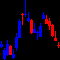

In [140]:
Imgdisplay(candlechart_dir + os.listdir(candlechart_dir)[0], height=180, width=180) # 생성된 캔들차트 샘플확인

In [156]:
# 캔들차트이미지를 데이터 셋으로
# 한 픽셀의 RGB 값, 한 변의 픽셀 수는 dimension
def image2dataarray(candlechart_dir):
    symbol = candlechart_dir.split('\\')[-3]
    imgs = list([])
    for i in range(len(os.listdir(candlechart_dir))):
        imgname = '{}-{}.png'.format(symbol, i)
        im = Image.open(candlechart_dir+imgname)
        pixels = list(im.getdata())
        img = list([])
        for pixel in pixels:
            for j in range(3): # Excepting alpha value
                img.append(pixel[j])
        imgs.append(img)
        # print(imgs)
    return np.array(imgs)

def label2dataarray(label_set_path):
    label_array = list([])
    with open(label_set_path, 'r') as f:
        lines = f.readlines()
        for line in lines:
            label = int(line.split(',')[-1])
            label_array.append(label)
        return np.array(label_array)

In [157]:
candle_array = image2dataarray(candlechart_dir)
label_array = label2dataarray(label_set_path)
print(len(candle_array), len(label_array))

220 220
